## Import libraries

In [1]:
import gc
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_log_error

import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow_addons.optimizers import AdamW, Lookahead
from tensorflow.keras.layers import Dense, Dropout, Add
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Input, Activation
from tensorflow.keras.losses import MeanSquaredLogarithmicError

## Prepare data for model training

In [2]:
with open("../input/workation-price-prediction-preprocess-data/Workation_Dataset.txt", 'rb') as handle: 
    data = handle.read()

processed_data = pickle.loads(data)
train_df = processed_data['train_df']
test_df = processed_data['test_df']

train_df = train_df[~((train_df['Per Person Price'] < 7.3) | (np.exp(train_df['Per Person Price']) > 150000))].copy()

del processed_data
gc.collect()

53

In [3]:
Xtrain = train_df.loc[:, train_df.columns != 'Per Person Price'].values
Ytrain = train_df['Per Person Price'].values
Ytrain_strat = pd.qcut(train_df['Per Person Price'].values, q=7, labels=range(0,7))
Xtest = test_df.values

print("Xtrain: {} \nYtrain: {} \nXtest: {}".format(Xtrain.shape, Ytrain.shape, Xtest.shape))

del train_df
del test_df
gc.collect()

Xtrain: (20989, 4728) 
Ytrain: (20989,) 
Xtest: (9000, 4728)


0

## Build the model

In [4]:
def head(x):
    
    x1 = x
    
    x2 = Dense(units=2048, name='Dense-1', kernel_initializer='he_uniform', 
                kernel_regularizer=l2(0.0005))(x1)
    x2 = BatchNormalization(name='BatchNorm-1')(x2)
    x2 = Activation('swish', name='Swish-1')(x2)
    x2 = Dropout(rate=0.5, name='Dropout-1')(x2)
    
    x2 = Dense(units=1536, name='Dense-2', kernel_initializer='he_uniform', 
               kernel_regularizer=l2(0.0005))(x2)
    x2 = BatchNormalization(name='BatchNorm-2')(x2)
    x2 = Activation('swish', name='Swish-2')(x2)
    x2 = Dropout(rate=0.5, name='Dropout-2')(x2)
    
    x = Add(name='Add-Embed')([x1, x2])
    x = BatchNormalization(name='BatchNorm-Embed')(x)
    
    x = Dense(units=1024, name='Dense-3', kernel_initializer='he_uniform', 
               kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization(name='BatchNorm-3')(x)
    x = Activation('swish', name='Swish-3')(x)
    x = Dropout(rate=0.5, name='Dropout-3')(x)
    
    x = Dense(units=512, name='Dense-4', kernel_initializer='he_uniform', 
               kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization(name='BatchNorm-4')(x)
    x = Activation('swish', name='Swish-4')(x)
    x = Dropout(rate=0.5, name='Dropout-4')(x)

    x = Dense(units=1, name='Output', 
              kernel_initializer='he_uniform')(x)
    
    return x

In [5]:
autoencoder = load_model('../input/workation-price-prediction-dae/DAE_model.h5')
autoencoder.trainable = False

model = Model(autoencoder.input, head(autoencoder.get_layer('Embedding').output),
              name='DNN_model')

model.compile(loss='mean_squared_logarithmic_error',
              optimizer=Lookahead(AdamW(lr=1e-2, 
                                        weight_decay=1e-5, 
                                        clipvalue=700), 
                                  sync_period=10))

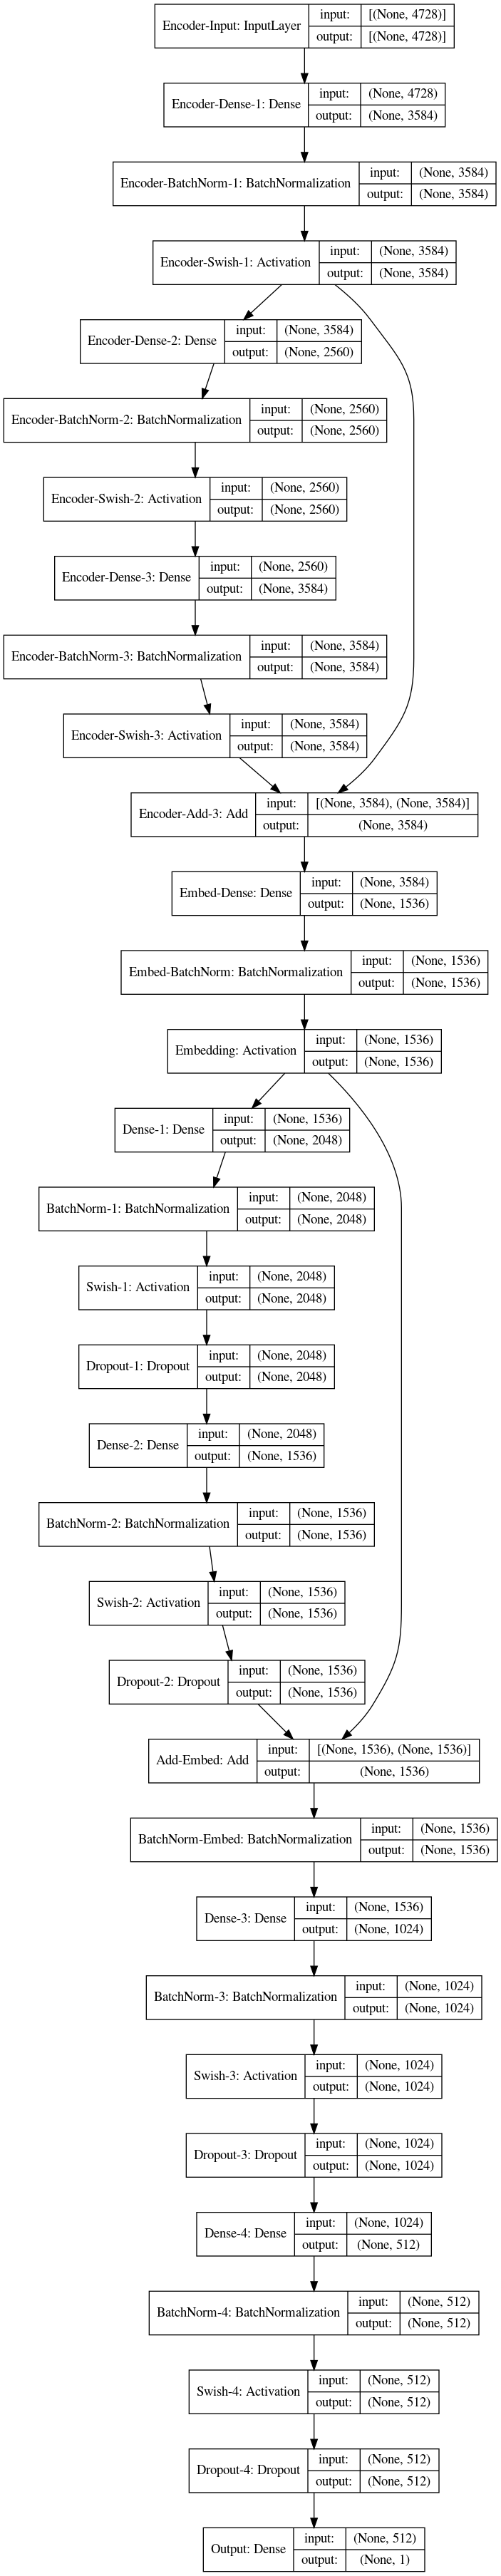

In [6]:
plot_model(
    model, to_file='./DNN_model.png', 
    show_shapes=True, show_layer_names=True
)

In [7]:
def custom_rmsle(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)
    msle = MeanSquaredLogarithmicError()
    return tf.math.sqrt(msle(y_true, y_pred))

In [8]:
FOLD = 7
NUM_SEED = 3
VERBOSE = 0
mini_batch_size = 128

np.random.seed(3)
seeds = np.random.randint(0, 100, size=NUM_SEED)

oof_score = 0
y_pred_meta_dnn = np.zeros((Ytrain.shape[0], NUM_SEED))
y_pred_final_dnn = np.zeros((Xtest.shape[0], NUM_SEED))
counter = 0


for sidx, seed in enumerate(seeds):
    seed_score = 0
    
    kfold = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed)

    for idx, (train, val) in enumerate(kfold.split(Xtrain, Ytrain_strat)):
        counter += 1

        train_x, train_y = Xtrain[train], Ytrain[train]
        val_x, val_y = Xtrain[val], Ytrain[val]

        model = Model(autoencoder.input, head(autoencoder.get_layer('Embedding').output),
                      name='DNN_model')
        
        model.compile(loss=custom_rmsle,
                      optimizer=Lookahead(AdamW(lr=5e-2, 
                                                weight_decay=1e-5, 
                                                clipvalue=700), 
                                          sync_period=10))

        early = EarlyStopping(monitor="val_loss", mode="min", 
                              restore_best_weights=True, 
                              patience=10, verbose=VERBOSE)

        reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, 
                                      min_lr=5e-6, patience=5, 
                                      verbose=VERBOSE, mode='min')

        chk_point = ModelCheckpoint('./DNN_model.h5', 
                                    monitor='val_loss', verbose=VERBOSE, 
                                    save_best_only=True, mode='min')

        history = model.fit(
            x=train_x, y=train_y, 
            batch_size=mini_batch_size, 
            epochs=275, 
            verbose=VERBOSE,
            callbacks=[reduce_lr, early, chk_point], 
            workers=5,
            validation_data=(val_x, val_y)
        )
        
        model = load_model('./DNN_model.h5', 
                           custom_objects={ 'custom_rmsle': custom_rmsle(y_true=np.zeros((Ytrain.shape[0],1)), 
                                                                         y_pred=np.zeros((Ytrain.shape[0],1))) })

        y_pred = model.predict(val_x)
        y_pred_meta_dnn[val, sidx] += y_pred.ravel()
        y_pred_final_dnn[:, sidx] += model.predict(Xtest).ravel()
        
        score = np.sqrt(mean_squared_log_error(val_y, y_pred))
        oof_score += score
        seed_score += score
        print("Seed-{} | Fold-{} | OOF Score: {}".format(seed, idx, score))
    
    print("\nSeed: {} | Aggregate OOF Score: {}\n\n".format(seed, (seed_score / FOLD)))


y_pred_final_dnn = y_pred_final_dnn / float(FOLD)
oof_score /= float(counter)
print("Aggregate OOF Score: {}".format(oof_score))

Seed-24 | Fold-0 | OOF Score: 0.015478399595716359
Seed-24 | Fold-1 | OOF Score: 0.015360683279581778
Seed-24 | Fold-2 | OOF Score: 0.015786801959819734
Seed-24 | Fold-3 | OOF Score: 0.015584117766080464
Seed-24 | Fold-4 | OOF Score: 0.015705294614771246
Seed-24 | Fold-5 | OOF Score: 0.015433041611941322
Seed-24 | Fold-6 | OOF Score: 0.015610837865688008

Seed: 24 | Aggregate OOF Score: 0.015565596670514131


Seed-3 | Fold-0 | OOF Score: 0.015734175957986887
Seed-3 | Fold-1 | OOF Score: 0.01521452675751194
Seed-3 | Fold-2 | OOF Score: 0.015458454611094016
Seed-3 | Fold-3 | OOF Score: 0.01528626974555357
Seed-3 | Fold-4 | OOF Score: 0.016669866095903766
Seed-3 | Fold-5 | OOF Score: 0.015164987946340892
Seed-3 | Fold-6 | OOF Score: 0.016000930632657513

Seed: 3 | Aggregate OOF Score: 0.015647030249578368


Seed-56 | Fold-0 | OOF Score: 0.01603092884570711
Seed-56 | Fold-1 | OOF Score: 0.014927118488272734
Seed-56 | Fold-2 | OOF Score: 0.01599602081703946
Seed-56 | Fold-3 | OOF Score: 0.0

In [9]:
np.savez_compressed('./DNN_Meta_Features.npz',
                    y_pred_meta_dnn=y_pred_meta_dnn, 
                    oof_score=oof_score,
                    y_pred_final_dnn=y_pred_final_dnn)

In [10]:
df = pd.DataFrame(y_pred_final_dnn)
df.head()

,0,1,2
0,9.848212,9.846320,9.856782
1,9.234676,9.250317,9.285187
2,8.648816,8.641687,8.639227
3,8.864596,8.850314,8.854847
4,9.925583,9.923047,9.929784
